<a href="https://colab.research.google.com/github/md-abu-shayid/Brain_Tumor_Detection_CNN/blob/main/Deep_Learning_with_PyTorch_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [25]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a815d451c5369fed3f702554dbc16fc6bd61955c0ed9e2033d552c0a13e6ef21
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4c3082a473d62d5727165fe21dddf5810e2a41a9ed99814f7216163bf8dd3340
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [26]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


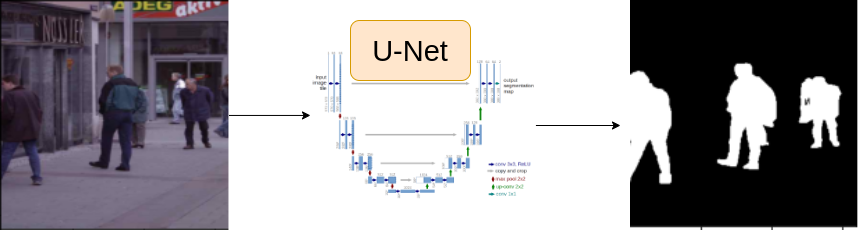

# Some Common Imports

In [27]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [28]:
import torch
import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [29]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
IMAGE_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [30]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [63]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [67]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

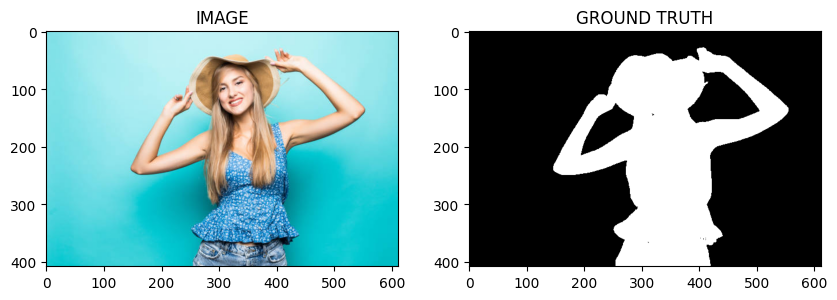

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [70]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state= 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [100]:
import albumentations as A

In [101]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False) #To disable checking the shape of images and masks

def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE)

  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [102]:
from torch.utils.data import Dataset

In [103]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h,w)
    mask = np.expand_dims(mask, axis = -1)  #(h,w.c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c)-> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/ 255.0
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask

In [104]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [105]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# Define a Data Visualization Function
This function will visualise data from the custom dataset

In [106]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

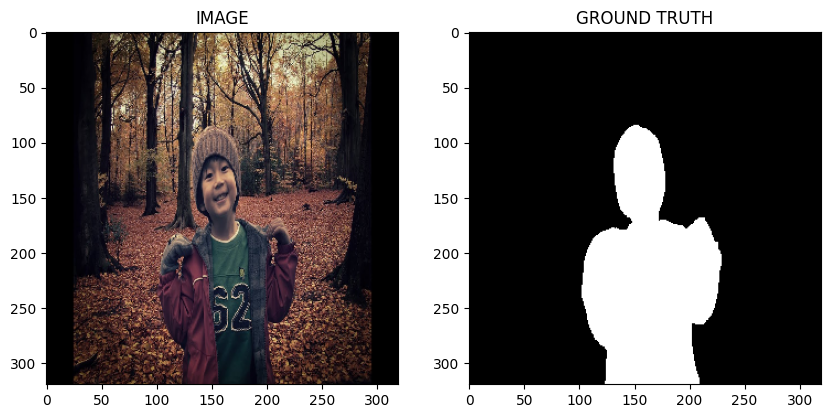

In [111]:
idx = 21
image, mask = trainset[idx]

show_image(image, mask)

# Task 5 : Load dataset into batches

In [113]:
from torch.utils.data import DataLoader

In [114]:
train_loader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
valid_loader = DataLoader(validset, batch_size = BATCH_SIZE)

In [116]:
print(f"Total no. of batches in trainloader : {len(train_loader)}")
print(f"Total no. of batches in validloader : {len(valid_loader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [118]:
for image, mask in train_loader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [119]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [132]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits



In [133]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

# Define a Train Function

In [134]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

  optimizer.zero_grad()
  logits, loss = model(images, masks)

  loss.backward()
  optimizer.step()

  total_loss += loss.item()

  return total_loss/ len(data_loader)

# Define a Evaluation Function

In [135]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/ len(data_loader)

# Task 8 : Train Model

In [136]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [138]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("The best Model is saved")

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


The best Model is saved
Epoch : 1 Train Loss : 0.08749063809712727 Valid_loss : 29.288387775421143


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


The best Model is saved
Epoch : 2 Train Loss : 0.0822983980178833 Valid_loss : 48.5711030960083


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


The best Model is saved
Epoch : 3 Train Loss : 0.06825792789459229 Valid_loss : 16.656959056854248


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


The best Model is saved
Epoch : 4 Train Loss : 0.06227270762125651 Valid_loss : 37.5752592086792


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


The best Model is saved
Epoch : 5 Train Loss : 0.05964821974436442 Valid_loss : 40.44539833068848


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


The best Model is saved
Epoch : 6 Train Loss : 0.05435137748718262 Valid_loss : 32.65624141693115


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


The best Model is saved
Epoch : 7 Train Loss : 0.04580702781677246 Valid_loss : 7.33130407333374


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


The best Model is saved
Epoch : 8 Train Loss : 0.049529107411702473 Valid_loss : 2.261296033859253


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


The best Model is saved
Epoch : 9 Train Loss : 0.03639068206151327 Valid_loss : 1.0432945638895035


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


The best Model is saved
Epoch : 10 Train Loss : 0.03299314777056376 Valid_loss : 1.2056126147508621


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


The best Model is saved
Epoch : 11 Train Loss : 0.029445441563924153 Valid_loss : 1.259801134467125


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


The best Model is saved
Epoch : 12 Train Loss : 0.041298433144887285 Valid_loss : 2.9379659295082092


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


The best Model is saved
Epoch : 13 Train Loss : 0.046121696631113686 Valid_loss : 6.461280405521393


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


The best Model is saved
Epoch : 14 Train Loss : 0.03536687692006429 Valid_loss : 11.216325163841248


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


The best Model is saved
Epoch : 15 Train Loss : 0.029087191820144652 Valid_loss : 7.717318415641785


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


The best Model is saved
Epoch : 16 Train Loss : 0.02943851947784424 Valid_loss : 6.387614607810974


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


The best Model is saved
Epoch : 17 Train Loss : 0.03811411857604981 Valid_loss : 4.01683121919632


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


The best Model is saved
Epoch : 18 Train Loss : 0.03519731362660726 Valid_loss : 1.7300299406051636


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


The best Model is saved
Epoch : 19 Train Loss : 0.0474289337793986 Valid_loss : 1.806869089603424


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


The best Model is saved
Epoch : 20 Train Loss : 0.028123404582341513 Valid_loss : 1.389790564775467


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


The best Model is saved
Epoch : 21 Train Loss : 0.03737391630808513 Valid_loss : 0.9579596668481827


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


The best Model is saved
Epoch : 22 Train Loss : 0.028166731198628742 Valid_loss : 0.764193519949913


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


The best Model is saved
Epoch : 23 Train Loss : 0.020779454708099367 Valid_loss : 0.6938982456922531


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


The best Model is saved
Epoch : 24 Train Loss : 0.02030937870343526 Valid_loss : 0.607257716357708


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


The best Model is saved
Epoch : 25 Train Loss : 0.021481871604919434 Valid_loss : 0.555536612868309


# Task 9 : Inference

In [146]:
idx = 3

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

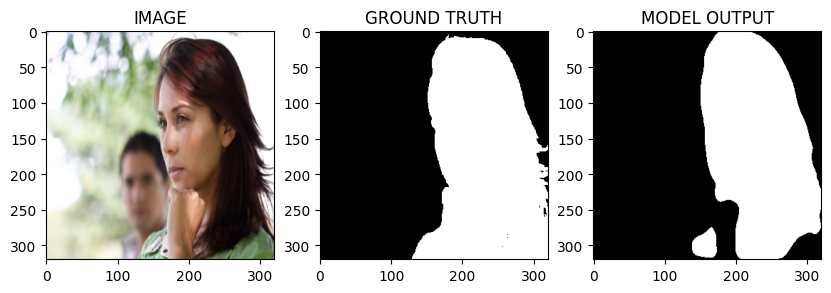

In [147]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Instagram : https://www.instagram.com/md.abushayid/

Linkedin : https://www.linkedin.com/in/md-abu-shayid-30a55b242/